## Introduction

We explore in this article how to easily generate your own Monte Carlo simulations in Python using a resource assessment as an example. The methodologies detailed here can however be adapted to any problem where a Monte Carlo simulation is desired.<!--more-->
There are many advantages to using Python for this: 
- It's totally free - no need for any extensions to Excel (or for Excel for that matter...);
- It's not a black box - you know what is happening under the hood;
- It's fully customizable - you can finally tailor the solution to your problem, including the outputs;
- It is easy to export your results to a wide variety of destinations, including raster and vector images, Excel spreadsheets, or even LaTeX documents.

Though some familiarity with Python is desirable, advanced knowledge of the language isn't needed and the code provided below should relatively easy to adapt to your own needs. We will mostly be using [SciPy's](https://www.scipy.org) [*statistical submodule*](https://docs.scipy.org/doc/scipy/reference/stats.html) for calculations, [Pandas](https://pandas.pydata.org) for generating and summarizing results, and a combination of [Matplotlib](https://matplotlib.org)/[seaborn](https://seaborn.pydata.org) for plotting.

First, we will see how we can generate random variates from a known distribution. We will then apply this knowledge and generate random variates for all the input parameters for a resource calculation before calculating the corresponding resource distribution and creating some reporting elements. Finally we will discuss potential next steps to take things a little further.


## Generating random variates from a distribution with SciPy

Let's generate $n$ random variates for a normal distribution with a mean of 3 and a standard deviation of 2. For this, we can use SciPy's [*norm*](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.norm.html) continuous distribution class to instantiate a normal distribution object with the desired paramaters: `distribution = norm(loc=3, scale=2)`. We can then use its [*rvs( )*](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.rv_continuous.rvs.html) method to generate \\( n \\) random variates.

### Import necessary libraries

In [43]:
from math import log, exp

import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
import numpy as np
import pandas as pd
from scipy.stats import (norm, lognorm, 
                         gamma, percentileofscore)

import seaborn as sns

### Generate random variates and ideal distribution

In [44]:
# instantiate normal distribution object with mean=3, std=2
distribution = norm(loc=3, scale=2)

# generate n random variates using 'rvs' method
n = 10_000
rv = distribution.rvs(int(n))

# generate (x, y) data for the ideal distribution
x = np.linspace(-6.5, 8.5)
probability = distribution.pdf(x)

### Display results

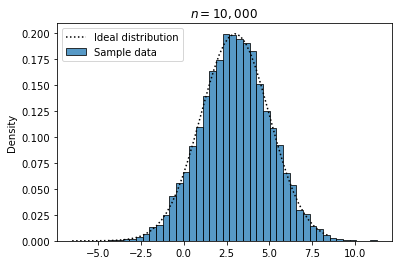

In [45]:
# create Pyplot axes for plotting results
fig, ax = plt.subplots()

# plot a histogram of the random variates with seaborn
sns.histplot(
    rv,
    bins=40,
    stat='density',
    ax=ax,
    label='Sample data'
)
    
# plot the ideal distribution
ax.plot(x, y, c='k', ls=':', 
        label='Ideal distribution')
    
# format title and add legend to plot
ax.set_title("$n={:,.0f}$".format(n))
ax.legend(loc='upper left')

plt.show()

### A note on distributions and their parameters in SciPy

In addition to the normal distribution used above, there are many others available in SciPy all featuring similar functionalities. The average geoscientist should easily find what they need:

- Log-normal ([*lognorm*](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.lognorm.html)) 
- Beta ([*beta*](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.beta.html))
- Triangular ([*triang*](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.triang.html))
- Truncated normal ([*truncnorm*](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.truncnorm.html))
- And many more (full list [here](https://docs.scipy.org/doc/scipy/reference/stats.html#continuous-distributions))

The parameters used to define these distributions are not always as user friendly as one might hope, and depending on the distribution some calculations may be needed to get to them. To make things a little simpler going forward, we will therefor create some functions to instantiate SciPy distribution objects using more user friendly parameters, especially for the log-normal distribution which we will also be using. The two functions below do this taking the $P_{90}$ and $P_{10}$ as input parameters.

In [46]:
def norm_dist(p90, p10):
    if p90 > p10:
        p90, p10 = p10, p90
    mean = (p90 + p10) / 2 
    std = (p10 - p90) / (norm.ppf(0.9) - norm.ppf(0.1))
    return norm(loc=mean, scale=std)
    

def lognorm_dist(p90, p10):
    if p90 > p10:
        p90, p10 = p10, p90
    std = log(p10 / p90) / (norm.ppf(0.9) - norm.ppf(0.1))
    mean = (log(p10) - 2**0.5 * std 
            * (gamma.ppf(0.8, a=0.5, scale=1))**0.5)
    return lognorm(s=std, scale=exp(mean))

## Generating random variates for volumetric parameters

Strong with this knowledge, we can now define distributions for the input parameters of our resource assessment and generate random variates for each parameter. 

In [66]:
# define volumetric parameters
params = {
    'GRV':      lognorm_dist(p90=100e6, p10=250e6),
    'NTG':      norm_dist(p90=0.6, p10=0.8),
    'Porosity': norm_dist(p90=0.125, p10=0.225),
    'Sw':       norm_dist(p90=0.15, p10=0.45),
    'FVF':      norm_dist(p90=1.1, p10=1.3),
    'RF':       norm_dist(p90=0.15, p10=0.25),
}

# number of samples in our simulation
num_samples = 100_000
#---------#---------#---------#---------#---------#---------#--------
# create an empty DataFrame with a column for each input parameter
realisations = pd.DataFrame([], columns=params)


# loop through parameters generating their random variates
# and storing the result in the right column of
# the DataFrame
seed = 2
for param, dist in params.items():
    realisations[param] = dist.rvs(
        num_samples,
        random_state=seed
    )
    seed = seed*2

> Note: defining the `random_state` argument in `rvs` is not a requirement. I have opted to do this here so the outputs are always the same (still 'random', just the same 'random' every time). I have been cautious to change the random state for each parameter to avoid unwanted correlation between parameters.

### Random variates summary

Using Pandas' [*describe( )*](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.describe.html?highlight=describe) method and specifying a list of `percentiles`, we can easily generate a summary table of statistics for the imput parameters. Along with our chosen percentiles, this will also provide mean, standard deviation, and min & max for each parameter. This is useful to check we have experimental distributions that matches our desired ones.

In [70]:
realisations.describe(percentiles=[0.1, 0.5, 0.9],)

,GRV,NTG,Porosity,Sw,FVF,RF
count,1.000000e+05,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.684093e+08,0.699863,0.175310,0.305519,1.200344,0.199975
std,6.246200e+07,0.077800,0.038069,0.107172,0.078205,0.039172
min,3.837896e+07,0.339578,0.100000,0.150000,0.853751,0.036569
10%,9.992398e+07,0.600324,0.124994,0.150000,1.100215,0.149634
50%,1.578452e+08,0.699836,0.174726,0.299628,1.200399,0.200028
90%,2.500421e+08,0.799543,0.225139,0.449945,1.300464,0.250159
max,7.547270e+08,1.000000,0.331260,0.700000,1.528683,0.363993


Close inspection reveals values for $NTG$, $Porosity$ and $S_w$ that fall outside of desired bounds. We can address this with Pandas' [*clip( )*](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.clip.html) method and clip these outlier values to more reasonable one.

In [69]:
realisations['Porosity'] = realisations['Porosity'].clip(lower=0.1)
realisations['Sw'] = realisations['Sw'].clip(lower=0.15, upper=0.70)
realisations['NTG'] = realisations['NTG'].clip(upper=1)

## Volumetric calculations and reporting




In [64]:
realisations['STOOIP'] = (realisations['GRV']
                     * realisations['NTG']
                     * realisations['Porosity']
                     * (1 - realisations['Sw'])
                     / realisations['FVF']
                     / 1_000 / 159)
realisations['Resource'] = realisations['STOOIP'] * realisations['RF']

<AxesSubplot:xlabel='STOOIP', ylabel='Proportion'>

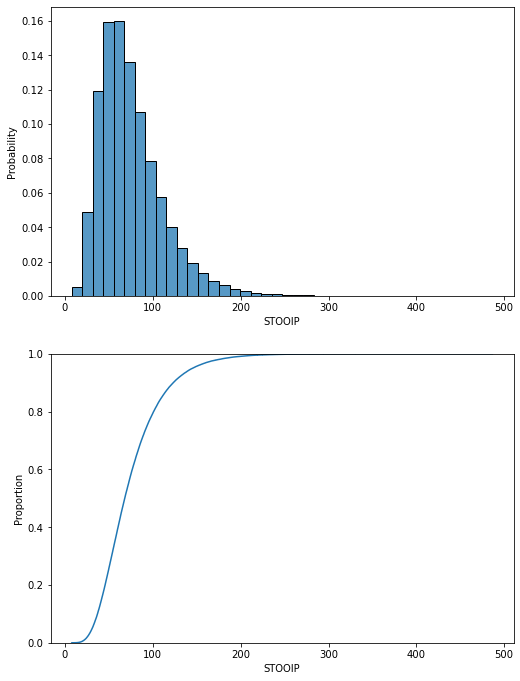

In [51]:
fig, ax = plt.subplots(nrows=2, figsize=(8.3, 11.7))

# display histogram of distribution in first subplot
sns.histplot(realisations.STOOIP, ax=ax[0], stat='probability', bins=40)

# display empirical cumulative distribution function in second subplot
sns.ecdfplot(realisations.STOOIP, ax=ax[1])

In [52]:
# display key percentiles and mean on cumulative plot
ax[0].set_xlim(left=0)
ax[0].set_ylim(ax[0].get_ylim()) # freeze ylim
ax[1].set_xlim(ax[0].get_xlim())
y_max = ax[0].get_ylim()[1]
ls = {'c':'k', 'ls': '--', 'lw': '1'}
for p in [0.1, 0.5, 0.9]:
    q = realisations.STOOIP.quantile(p)
    ax[0].plot([q] * 2, [0, y_max], **ls)
    ax[1].plot([0] + [q] * 2,
               [p] * 2 + [0],
               **ls)
    ax[1].annotate('{:.1f}'.format(q), 
                   (q, p),
                   xytext=(3, 3),
                   textcoords='offset pixels',
                   c='k')
    
ls_mean = {'c':'r', 'ls': '--', 'lw': '1'}
mean = realisations.STOOIP.mean()
Pmean = percentileofscore(realisations.STOOIP,
                          mean, kind='weak') / 100
ax[0].plot([mean] * 2, [0, y_max],
           **ls_mean)
ax[1].plot([0] + [mean] * 2, [Pmean] * 2 + [0],
           **ls_mean)
ax[1].annotate('$Mean={:.1f}$'.format(mean), 
               (mean, Pmean),
               xytext=(3, 3),
               textcoords='offset pixels',
               c='r')

Text(3, 3, '$Mean=75.5$')

In [53]:
plt.show()

Save figure

In [54]:
summary = realisations.describe(percentiles=[0.1, 0.5, 0.9],).T \
    .iloc[:,[3,4,5,6,7,1]]
summary.columns = ['Min', 'P90', 'P50', 'P10', 'Max', 'Mean']
summary

,Min,P90,P50,P10,Max,Mean
GRV,3.837896e+07,9.992398e+07,1.578452e+08,2.500421e+08,7.547270e+08,1.684093e+08
NTG,3.395776e-01,6.003238e-01,6.998363e-01,7.995425e-01,1.029001e+00,6.998636e-01
Porosity,1.000000e-01,1.249936e-01,1.747259e-01,2.251387e-01,3.312596e-01,1.753103e-01
Sw,1.500000e-01,1.500000e-01,2.996280e-01,4.499451e-01,7.000000e-01,3.055189e-01
FVF,8.537509e-01,1.100215e+00,1.200399e+00,1.300464e+00,1.528683e+00,1.200344e+00
RF,3.656859e-02,1.496338e-01,2.000276e-01,2.501588e-01,3.639929e-01,1.999747e-01
STOOIP,7.488700e+00,3.692494e+01,6.797166e+01,1.232714e+02,4.868506e+02,7.546393e+01
Resource,1.107679e+00,6.826468e+00,1.334368e+01,2.550345e+01,1.008095e+02,1.509399e+01


export to Excel

In [55]:
summary.to_excel('./summary.xlsx')

## Where next?

- [ ] correlated variables
- [ ] area depth from grid
- [ ] GRV from 2 grids
- [ ] risked distributions
- [ ] multiple prospects / consolidation

pseudo-randomness, sampling, LHC etc. SciPY QMC...

In [56]:
num_samples = 20_000_000


realisations = pd.DataFrame([], columns=params)

for k, v in params.items():
    realisations[k] = v.rvs(num_samples)

In [57]:
realisations.Porosity = realisations.Porosity.clip(lower=0.1)
realisations.Sw = realisations.Sw.clip(lower=0.15)
realisations['STOOIP'] = (realisations['GRV']
                     * realisations['NTG']
                     * realisations['Porosity']
                     * (1 - realisations['Sw'])
                     / realisations['FVF']
                     / 1_000 / 159)
realisations['Resource'] = realisations['STOOIP'] * realisations['RF']

In [58]:
summary_stats = realisations.Resource.groupby(by=np.arange(200). \
                                repeat(100_000)). \
                                quantile([0.1, 0.5, 0.9]). \
                                unstack()
summary_stats['Mean'] = realisations.Resource.groupby(by=np.arange(200). \
                                repeat(100_000)). \
                                mean()
summary_stats = summary_stats / summary_stats.mean()

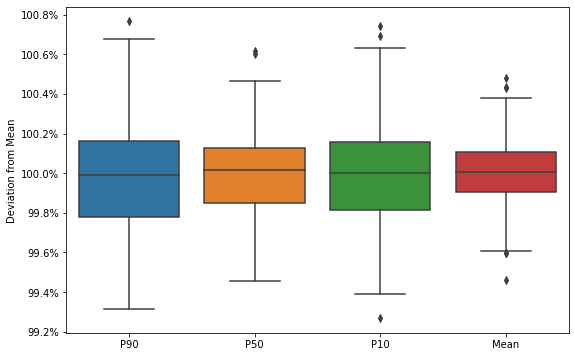

<Figure size 432x288 with 0 Axes>

In [59]:
fig, ax = plt.subplots(figsize=(9,6))
summary_stats.columns = ['P90', 'P50', 'P10', 'Mean']
sns.boxplot(data=summary_stats.melt(value_name='Deviation from Mean'), 
            x='variable', 
            y='Deviation from Mean', 
            ax=ax)
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:.1%}'))
ax.set_xlabel(None)
plt.show()
plt.savefig('sensitivity.png')